In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, r_regression
from scipy import stats
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn import svm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt.space import Real
from skopt.space import Categorical
from skopt import BayesSearchCV

In [6]:
import os

os.listdir('../../../dataset/extracted_features/')

['extracted_features.csv']

In [7]:
cleaned_df=pd.read_csv('../../../dataset/extracted_features/extracted_features.csv')
cleaned_df.set_index('url',inplace=True)
cleaned_df=cleaned_df.replace({'legitimate': 0, 'phishing': 1})
cleaned_df.rename(columns = {'status':'phishing'}, inplace = True)

In [8]:
selector = VarianceThreshold()
selector.fit_transform(cleaned_df)

array([[  0,   0,  37, ...,   0,   0,   0],
       [  1,   0,  77, ...,   0,   0,   0],
       [  1,   1, 126, ...,   0,   0,   0],
       ...,
       [  0,   1, 105, ...,   0,   0,   0],
       [  0,   0,  38, ...,   0,   0,   0],
       [  1,   0, 477, ...,   0,   0,   0]], dtype=int64)

In [9]:
cleaned_df=cleaned_df.loc[:, selector.get_support()]

In [10]:
features=cleaned_df.loc[:,'https_true':]
label=cleaned_df.loc[:,'phishing']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3,random_state=42)

In [12]:
fc = SelectKBest(score_func=f_classif, k=30)
fc.fit(X_train,y_train)
X_train_selected=X_train.loc[:, fc.get_support()]
X_test_selected=X_test.loc[:, fc.get_support()]

c:\Users\patri\anaconda3\envs\phishing\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\patri\anaconda3\envs\phishing\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
def hyperpara_opt(train_x,train_y):
  tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1, 10, 100, 1000],'gamma':[0.1,0.01,0.001,0.0001]},
                    {'kernel': ['linear'], 'C': [0.1,1, 10, 100, 1000],'gamma':[0.1,0.01,0.001,0.0001]},
                     {'kernel': ['sigmoid'], 'C': [0.1,1, 10, 100, 1000],'gamma':[0.1,0.01,0.001,0.0001]}]
                    #{'kernel': ['poly'], 'C': [0.1,1, 10, 100, 1000],'gamma':[0.1,0.01,0.001]}]
  grid=GridSearchCV(svm.SVC(),param_grid=tuned_parameters,verbose=20,n_jobs=-4,cv=4, scoring='accuracy')
  grid.fit(train_x,train_y)
  #model= svm.SVC(C=grid.best_estimator_.C, gamma=grid.best_estimator_.gamma,kernel=grid.best_estimator_.kernel)
  #model.fit(train_x,train_y)
  print(grid.best_estimator_)
  print('Best score for data:', grid.best_score_)
  print('Best C:',grid.best_estimator_.C) 
  print('Best Kernel:',grid.best_estimator_.kernel)
  print('Best Gamma:',grid.best_estimator_.gamma)
  #return model

In [ ]:
hyperpara_opt(X_train,y_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
SVC(C=100, gamma=0.01)
Best score for data: 0.8187739255372315
Best C: 100
Best Kernel: rbf
Best Gamma: 0.01

[LibSVM]Accuracy: 0.8078156897054535
Recall: 0.7766647024160283


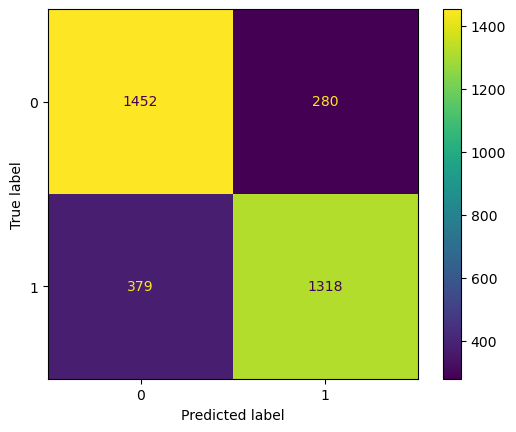

In [13]:
clf = svm.SVC(kernel='rbf',C=100,gamma=0.01,verbose=True)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [ ]:
def hyperpara_random_opt(train_x,train_y):
  tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1, 10, 100, 1000],'gamma':[0.1,0.01,0.001]},
                    {'kernel': ['linear'], 'C': [0.1,1, 10, 100, 1000],'gamma':[0.1,0.01,0.001]},
                     {'kernel': ['sigmoid'], 'C': [0.1,1, 10, 100, 1000],'gamma': [0.1,0.01,0.001]}]
                    #{'kernel': ['poly'], 'C': [0.1,1, 10, 100, 1000],'gamma':[0.1,0.01,0.001]}]
  random=RandomizedSearchCV(svm.SVC(),param_distributions=tuned_parameters,verbose=20,n_jobs=-4,cv=4, scoring='accuracy')
  random.fit(train_x,train_y)
  #model= svm.SVC(C=grid.best_estimator_.C, gamma=grid.best_estimator_.gamma,kernel=grid.best_estimator_.kernel)
  #model.fit(train_x,train_y)
  print(random.best_estimator_)
  print('Best score for data:', random.best_score_)
  print('Best C:',random.best_estimator_.C) 
  print('Best Kernel:',random.best_estimator_.kernel)
  print('Best Gamma:',random.best_estimator_.gamma)

In [ ]:
hyperpara_random_opt(X_train_selected,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
SVC(C=10, gamma=0.001)
Best score for data: 0.799276111944028 
Best C: 10 Best Kernel: rbf 
Best Gamma: 0.001

[LibSVM]Accuracy: 0.7981918926800816
Recall: 0.7583971714790807


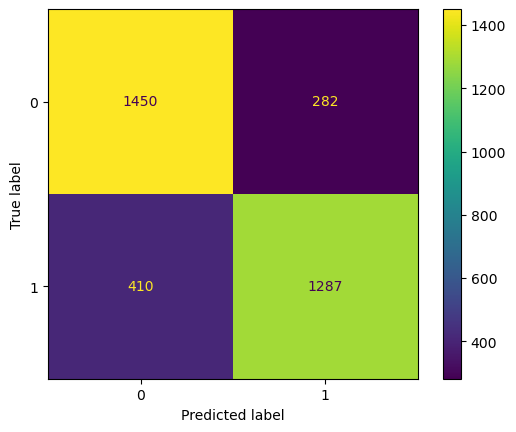

In [14]:
clf = svm.SVC(kernel='rbf',C=10,gamma=0.001,verbose=True)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [ ]:
params = {
    'C': Real(1e-6, 100, prior='log-uniform'),
    'gamma': Real(1e-6, 100, prior='log-uniform'),
    'kernel': Categorical(['linear', 'sigmoid', 'rbf']),
}

In [ ]:
opt = BayesSearchCV(
    svm.SVC(),
    search_spaces=params,
    cv=4,
    scoring='accuracy',
    #random_state=42,
    n_iter=20,
    verbose=1,
)
np.int = int

In [ ]:
opt.fit(X_train_selected,y_train)

0.8168991754122938
OrderedDict([('C', 40.75578686240225), ('gamma', 0.012721120945522295), ('kernel', 'rbf')])

[LibSVM]Accuracy: 0.8101487314085739
Recall: 0.7813789039481438


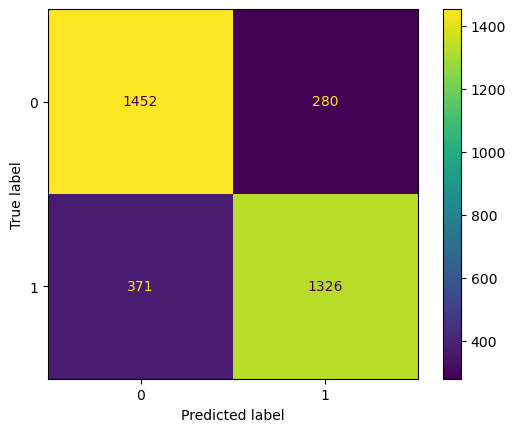

In [15]:
clf = svm.SVC(kernel='rbf',C=40.75578686240225,gamma=0.012721120945522295,verbose=True)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()